In [1]:
%matplotlib inline
import matplotlib.pyplot as plt

import numpy as np
import pandas as pd 
import seaborn as sns

from sklearn.metrics import mean_squared_error
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.preprocessing import StandardScaler

scl=StandardScaler()

import statsmodels.api as sm
import warnings
warnings.filterwarnings("ignore")

### Прочитайте базу my_BRENT2019.csv 

In [2]:
path_brent = 'my_BRENT2019.csv'
brent_data = pd.read_csv(path_brent,sep = ',', index_col=[0], parse_dates=[0])
brent_data.head()

,Значение,year,month,dayofmonth,quarter,dayofyear,weekofyear,dayofweek,is_holiday,is_prev_holiday,is_next_holiday
Дата,,,,,,,,,,,
2010-09-01,76.37,2010,9,1,3,244,35,2,0,0,0
2010-09-02,76.89,2010,9,2,3,245,35,3,0,0,0
2010-09-03,76.57,2010,9,3,3,246,35,4,0,0,0
2010-09-04,76.62,2010,9,4,3,247,35,5,0,0,0
2010-09-05,76.63,2010,9,5,3,248,35,6,0,1,0


In [3]:
brent_data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2667 entries, 2010-09-01 to 2019-09-01
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Значение         2667 non-null   float64
 1   year             2667 non-null   int64  
 2   month            2667 non-null   int64  
 3   dayofmonth       2667 non-null   int64  
 4   quarter          2667 non-null   int64  
 5   dayofyear        2667 non-null   int64  
 6   weekofyear       2667 non-null   int64  
 7   dayofweek        2667 non-null   int64  
 8   is_holiday       2667 non-null   int64  
 9   is_prev_holiday  2667 non-null   int64  
 10  is_next_holiday  2667 non-null   int64  
dtypes: float64(1), int64(10)
memory usage: 250.0 KB


In [4]:
p =3

#добавляем историю длиной р
for i in range(p):
    brent_data['t'+str(p-i+1)]=0.0
    brent_data['t'+str(p-i+1)].values[p+2:] = brent_data['Значение'].values[i+1:-(p-i+1)]
for i in range(p):
    brent_data['d'+str(p-i+1)]=0.0    
    brent_data['d'+str(p-i+1)].values[i+1:] =( (brent_data['Значение'].values[i+1:]- brent_data['Значение'].values[i:-1]))

### Добавьте первые разности и стоимости доллара и евро к рублю(можно добавить их 1-е разности)

In [5]:
first_diff = np.array(brent_data.iloc[1:,0].values - brent_data.iloc[:-1,0].values).astype('float32') 
brent_data['diff1'] = 0.0
brent_data['diff1'] =  brent_data['diff1'].astype('float') 
brent_data['diff1'].values[1:] = first_diff

In [6]:
rub_doll=pd.read_excel('RC_F01_09_2010_T01_09_2019_usd.xlsx')
rub_doll.index = pd.to_datetime(rub_doll['data'].values).date
rub_doll.drop(['nominal','cdx','data'], axis=1,inplace = True)
rub_doll.columns = ['doll']
rub_doll.head()

,doll
2010-09-01,30.8669
2010-09-02,30.8001
2010-09-03,30.6858
2010-09-04,30.6922
2010-09-07,30.5771


In [7]:
rub_euro=pd.read_excel('RC_F01_09_2010_T01_09_2019_euro.xlsx')
rub_euro.index = pd.to_datetime(rub_euro['data'].values).date
rub_euro.drop(['nominal','cdx','data'], axis=1,inplace = True)
rub_euro.columns = ['euro']
rub_euro.head()

,euro
2010-09-01,39.0127
2010-09-02,39.1654
2010-09-03,39.2901
2010-09-04,39.3505
2010-09-07,39.4720


In [8]:
brent_data = brent_data.merge(rub_doll['doll'], how='left',left_index=True, right_index=True)
brent_data = brent_data.merge(rub_euro['euro'], how='left',left_index=True, right_index=True)
brent_data = brent_data.fillna(method='ffill')

In [9]:
brent_data.head()

,Значение,year,month,dayofmonth,quarter,dayofyear,weekofyear,dayofweek,is_holiday,is_prev_holiday,is_next_holiday,t4,t3,t2,d4,d3,d2,diff1,doll,euro
Дата,,,,,,,,,,,,,,,,,,,,
2010-09-01,76.37,2010,9,1,3,244,35,2,0,0,0,0.0,0.0,0.0,0.00,0.00,0.00,0.00,30.8669,39.0127
2010-09-02,76.89,2010,9,2,3,245,35,3,0,0,0,0.0,0.0,0.0,0.52,0.00,0.00,0.52,30.8001,39.1654
2010-09-03,76.57,2010,9,3,3,246,35,4,0,0,0,0.0,0.0,0.0,-0.32,-0.32,0.00,-0.32,30.6858,39.2901
2010-09-04,76.62,2010,9,4,3,247,35,5,0,0,0,0.0,0.0,0.0,0.05,0.05,0.05,0.05,30.6922,39.3505
2010-09-05,76.63,2010,9,5,3,248,35,6,0,1,0,0.0,0.0,0.0,0.01,0.01,0.01,0.01,30.6922,39.3505


In [10]:
first_diff_doll = np.array(brent_data['doll'].values[1:] - brent_data['doll'].values[:-1]).astype('float32') 
brent_data['diff1_d'] = 0.0
brent_data['diff1_d'] =  brent_data['diff1_d'].astype('float') 
brent_data['diff1_d'].values[1:] = first_diff_doll

In [11]:
first_diff_euro = np.array(brent_data['euro'].values[1:] - brent_data['euro'].values[:-1]).astype('float32') 
brent_data['diff1_e'] = 0.0
brent_data['diff1_e'] =  brent_data['diff1_e'].astype('float') 
brent_data['diff1_e'].values[1:] = first_diff_euro

In [12]:
brent_data.head()

,Значение,year,month,dayofmonth,quarter,dayofyear,weekofyear,dayofweek,is_holiday,is_prev_holiday,...,t3,t2,d4,d3,d2,diff1,doll,euro,diff1_d,diff1_e
Дата,,,,,,,,,,,,,,,,,,,,,
2010-09-01,76.37,2010,9,1,3,244,35,2,0,0,...,0.0,0.0,0.00,0.00,0.00,0.00,30.8669,39.0127,0.0000,0.0000
2010-09-02,76.89,2010,9,2,3,245,35,3,0,0,...,0.0,0.0,0.52,0.00,0.00,0.52,30.8001,39.1654,-0.0668,0.1527
2010-09-03,76.57,2010,9,3,3,246,35,4,0,0,...,0.0,0.0,-0.32,-0.32,0.00,-0.32,30.6858,39.2901,-0.1143,0.1247
2010-09-04,76.62,2010,9,4,3,247,35,5,0,0,...,0.0,0.0,0.05,0.05,0.05,0.05,30.6922,39.3505,0.0064,0.0604
2010-09-05,76.63,2010,9,5,3,248,35,6,0,1,...,0.0,0.0,0.01,0.01,0.01,0.01,30.6922,39.3505,0.0000,0.0000


In [13]:
brent_data['Date'] = brent_data.index
brent_data['Date'] =  brent_data['Date'].astype('datetime64')
brent_data = brent_data.set_index(['Date'])
brent_data.head()

,Значение,year,month,dayofmonth,quarter,dayofyear,weekofyear,dayofweek,is_holiday,is_prev_holiday,...,t3,t2,d4,d3,d2,diff1,doll,euro,diff1_d,diff1_e
Date,,,,,,,,,,,,,,,,,,,,,
2010-09-01,76.37,2010,9,1,3,244,35,2,0,0,...,0.0,0.0,0.00,0.00,0.00,0.00,30.8669,39.0127,0.0000,0.0000
2010-09-02,76.89,2010,9,2,3,245,35,3,0,0,...,0.0,0.0,0.52,0.00,0.00,0.52,30.8001,39.1654,-0.0668,0.1527
2010-09-03,76.57,2010,9,3,3,246,35,4,0,0,...,0.0,0.0,-0.32,-0.32,0.00,-0.32,30.6858,39.2901,-0.1143,0.1247
2010-09-04,76.62,2010,9,4,3,247,35,5,0,0,...,0.0,0.0,0.05,0.05,0.05,0.05,30.6922,39.3505,0.0064,0.0604
2010-09-05,76.63,2010,9,5,3,248,35,6,0,1,...,0.0,0.0,0.01,0.01,0.01,0.01,30.6922,39.3505,0.0000,0.0000


### сделайте ее перрасчет (ресемплинг) в представление по неделям. 

In [14]:
brent_data_w = brent_data.resample('W').mean()
brent_data_w.head()

,Значение,year,month,dayofmonth,quarter,dayofyear,weekofyear,dayofweek,is_holiday,is_prev_holiday,...,t3,t2,d4,d3,d2,diff1,doll,euro,diff1_d,diff1_e
Date,,,,,,,,,,,,,,,,,,,,,
2010-09-05,76.616000,2010.0,9.000000,3.000000,3.000000,246.000000,35.0,4.000000,0.000000,0.2,...,0.000000,0.000000,0.052000,-0.052000,0.012000,0.052000,30.747440,39.233840,-0.034940,0.067560
2010-09-12,77.673333,2010.0,9.000000,8.500000,3.000000,251.500000,36.0,2.500000,0.166667,0.0,...,76.980000,77.086667,0.288333,0.288333,0.288333,0.288333,30.777050,39.302883,0.033583,-0.026467
2010-09-19,78.693333,2010.0,9.000000,15.666667,3.000000,258.666667,37.0,2.666667,0.000000,0.0,...,78.578333,78.788333,-0.021667,-0.021667,-0.021667,-0.021667,30.844500,39.764250,0.021433,0.187483
2010-09-26,78.518333,2010.0,9.000000,22.666667,3.000000,265.666667,38.0,2.666667,0.000000,0.0,...,78.351667,78.261667,0.118333,0.118333,0.118333,0.118333,31.012233,40.967983,-0.003200,0.203567
2010-10-03,81.211667,2010.0,9.333333,19.666667,3.333333,272.666667,39.0,2.666667,0.000000,0.0,...,78.888333,79.585000,0.791667,0.791667,0.791667,0.791667,30.607417,41.345817,-0.081750,-0.016467


In [15]:
brent_data_w.drop(['dayofmonth','dayofyear', 'dayofweek'],  axis=1, inplace=True)
brent_data_w.head()

,Значение,year,month,quarter,weekofyear,is_holiday,is_prev_holiday,is_next_holiday,t4,t3,t2,d4,d3,d2,diff1,doll,euro,diff1_d,diff1_e
Date,,,,,,,,,,,,,,,,,,,
2010-09-05,76.616000,2010.0,9.000000,3.000000,35.0,0.000000,0.2,0.000000,0.000000,0.000000,0.000000,0.052000,-0.052000,0.012000,0.052000,30.747440,39.233840,-0.034940,0.067560
2010-09-12,77.673333,2010.0,9.000000,3.000000,36.0,0.166667,0.0,0.166667,76.806667,76.980000,77.086667,0.288333,0.288333,0.288333,0.288333,30.777050,39.302883,0.033583,-0.026467
2010-09-19,78.693333,2010.0,9.000000,3.000000,37.0,0.000000,0.0,0.000000,78.366667,78.578333,78.788333,-0.021667,-0.021667,-0.021667,-0.021667,30.844500,39.764250,0.021433,0.187483
2010-09-26,78.518333,2010.0,9.000000,3.000000,38.0,0.000000,0.0,0.000000,78.555000,78.351667,78.261667,0.118333,0.118333,0.118333,0.118333,31.012233,40.967983,-0.003200,0.203567
2010-10-03,81.211667,2010.0,9.333333,3.333333,39.0,0.000000,0.0,0.000000,78.440000,78.888333,79.585000,0.791667,0.791667,0.791667,0.791667,30.607417,41.345817,-0.081750,-0.016467


In [16]:
brent_data_w.loc['2011-10-16'] = (brent_data_w.loc['2011-10-09'] + brent_data_w.loc['2011-10-23'])/2

### Постройте модель предсказания 1-й точки от текущей (h=1).

In [17]:
scl_target=StandardScaler() 

h=1
target = brent_data_w["Значение"].values[h:].reshape((brent_data_w.shape[0]-h,1))
y = scl_target.fit_transform(target)
y.shape

(469, 1)

In [18]:
scl_x=StandardScaler() 

X = brent_data_w.iloc[:-h,:].values
X = scl_x.fit_transform(X.astype('float64'))
X.shape

(469, 19)

In [19]:
# сделаем функцию разбиения
def split_data( data, split_date ):
    return data.loc[data.index.get_level_values('Date') <= split_date].copy(), \
           data.loc[data.index.get_level_values('Date') >  split_date].copy()

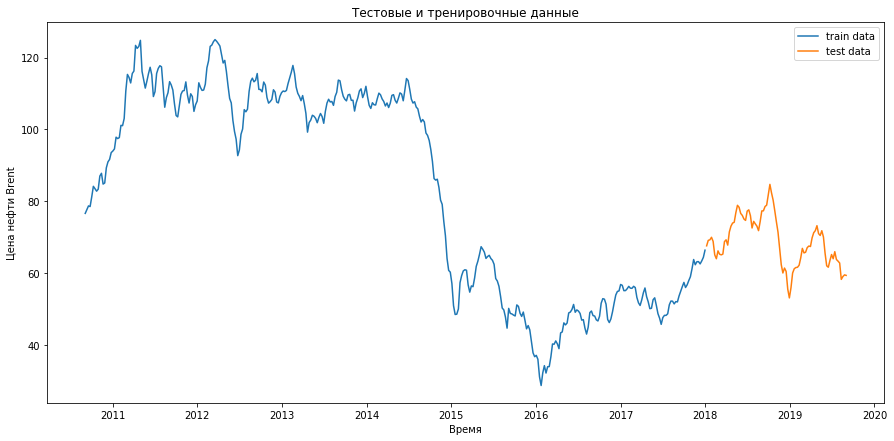

In [20]:
train, test = split_data(brent_data_w, '01-01-2018')

plt.figure( figsize=( 15, 7 ))
plt.xlabel('Время')
plt.ylabel('Цена нефти Brent')
plt.plot(train.index.get_level_values('Date'),train['Значение'], label='train data' )
plt.plot(test.index.get_level_values('Date'),test['Значение'], label='test data')
plt.title( 'Тестовые и тренировочные данные' )
plt.legend()
plt.show()

In [21]:
X_train = train.iloc[:-h, :]
y_train = train['Значение'].values[h:]
X_test = test.iloc[:-h, :]
y_test = test['Значение'].values[h:]

In [22]:
model_gb = GradientBoostingRegressor(max_depth=5, random_state=0, n_estimators=100)
model_gb.fit(X_train, y_train)

GradientBoostingRegressor(alpha=0.9, ccp_alpha=0.0, criterion='friedman_mse',
                          init=None, learning_rate=0.1, loss='ls', max_depth=5,
                          max_features=None, max_leaf_nodes=None,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=1, min_samples_split=2,
                          min_weight_fraction_leaf=0.0, n_estimators=100,
                          n_iter_no_change=None, presort='deprecated',
                          random_state=0, subsample=1.0, tol=0.0001,
                          validation_fraction=0.1, verbose=0, warm_start=False)

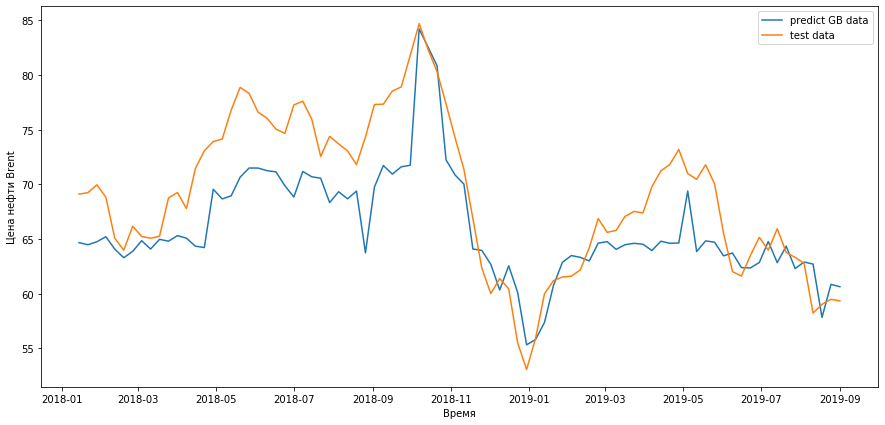

In [24]:
y_test_pred_g = model_gb.predict(X_test)

plt.figure( figsize=( 15, 7 ))


plt.xlabel('Время')
plt.ylabel('Цена нефти Brent')
plt.plot(test.index[h:],y_test_pred_g, label='predict GB data' )
plt.plot(test.index[h:],y_test, label='test data')

plt.legend()
plt.show()

In [25]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score

In [26]:
er_s = mean_squared_error(y_true=y_test, y_pred=y_test_pred_g) 
er_a = mean_absolute_error(y_true=y_test, y_pred=y_test_pred_g) 
er_r2 = r2_score(y_true=y_test, y_pred=y_test_pred_g)

print('ошибка mse :  ', er_s,'\nошибка mae  :  ', er_a,'\nоценка R2 :  ', er_r2)

ошибка mse :   19.969732313398303 
ошибка mae  :   3.6057451645440324 
оценка R2 :   0.5706821632452077


In [27]:
def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [28]:
er_g = mean_absolute_percentage_error(y_true=scl_target.inverse_transform( y_test),y_pred = scl_target.inverse_transform( y_test_pred_g))

print('ошибка градиентного бустинга MAPE :  ', er_g,'%')

ошибка градиентного бустинга MAPE :   4.849134489790021 %


In [35]:
from sklearn.model_selection import RandomizedSearchCV

def report(results, n_top=3):
    for i in range(1, n_top + 1):
        candidates = np.flatnonzero(results['rank_test_score'] == i)
        for candidate in candidates:
            print("Model with rank: {0}".format(i))
            print("Mean validation score: {0:.3f} (std: {1:.3f})".format(
                  results['mean_test_score'][candidate],
                  results['std_test_score'][candidate]))
            print("Parameters: {0}".format(results['params'][candidate]))
            print("")

param_dist = {"max_depth": [3, 2,1,4,5], 
              "n_estimators":[100,200,300,400,500]}

#  randomized search
n_iter_search = 10

model_gr =GradientBoostingRegressor()

random_search = RandomizedSearchCV(model_gr, param_distributions=param_dist, n_iter=n_iter_search, cv=5, iid=False)

random_search.fit(X_train, y_train)

report(random_search.cv_results_)

Model with rank: 1
Mean validation score: 0.874 (std: 0.082)
Parameters: {'n_estimators': 500, 'max_depth': 3}

Model with rank: 2
Mean validation score: 0.872 (std: 0.085)
Parameters: {'n_estimators': 300, 'max_depth': 3}

Model with rank: 3
Mean validation score: 0.871 (std: 0.080)
Parameters: {'n_estimators': 400, 'max_depth': 3}



In [34]:
model_gb_best = GradientBoostingRegressor(max_depth=3,  n_estimators=400)
model_gb_best.fit( X_train, y_train ) 
y_test_pred_g = model_gb_best.predict(X_test)

er_g = mean_absolute_percentage_error(y_true=scl_target.inverse_transform( y_test),y_pred = scl_target.inverse_transform( y_test_pred_g))
print('ошибка градиентного бустинга MAPE :  ', er_g,'%')

ошибка градиентного бустинга MAPE :   5.78876241929349 %


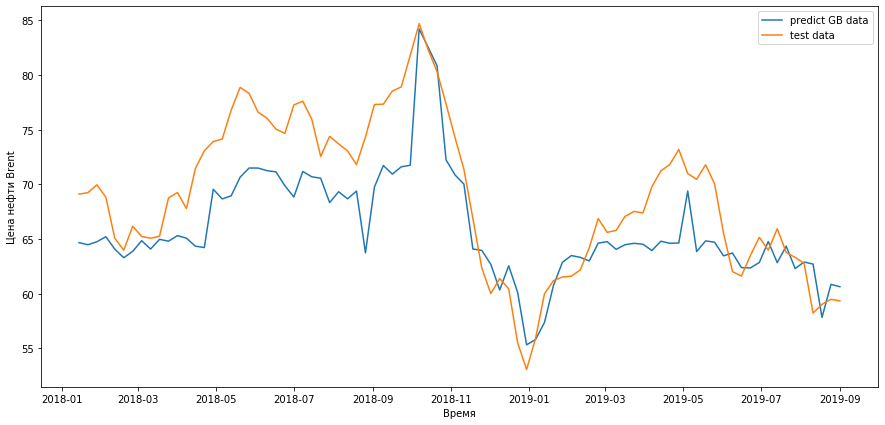

In [36]:
y_test_pred_g = model_gb.predict(X_test)

plt.figure( figsize=( 15, 7 ))


plt.xlabel('Время')
plt.ylabel('Цена нефти Brent')
plt.plot(test.index[h:],y_test_pred_g, label='predict GB data' )
plt.plot(test.index[h:],y_test, label='test data')

plt.legend()
plt.show()

### Добавьте еще один экзогенный фактор - любой:)

In [39]:
gold=pd.read_excel('gold_russian_bank.xlsx')
gold.index = pd.to_datetime(gold['data'].values).date
gold.drop(['data'], axis=1,inplace = True)
gold.columns = ['gold']
gold.head()

,gold
2010-09-01,1224.12
2010-09-02,1237.81
2010-09-03,1230.99
2010-09-04,1235.44
2010-09-07,1228.35


In [42]:
brent_data = brent_data.merge(gold['gold'], how='left',left_index=True, right_index=True)
brent_data = brent_data.fillna(method='ffill')

In [43]:
brent_data.head()

,Значение,year,month,dayofmonth,quarter,dayofyear,weekofyear,dayofweek,is_holiday,is_prev_holiday,...,t2,d4,d3,d2,diff1,doll,euro,diff1_d,diff1_e,gold
Date,,,,,,,,,,,,,,,,,,,,,
2010-09-01,76.37,2010,9,1,3,244,35,2,0,0,...,0.0,0.00,0.00,0.00,0.00,30.8669,39.0127,0.0000,0.0000,1224.12
2010-09-02,76.89,2010,9,2,3,245,35,3,0,0,...,0.0,0.52,0.00,0.00,0.52,30.8001,39.1654,-0.0668,0.1527,1237.81
2010-09-03,76.57,2010,9,3,3,246,35,4,0,0,...,0.0,-0.32,-0.32,0.00,-0.32,30.6858,39.2901,-0.1143,0.1247,1230.99
2010-09-04,76.62,2010,9,4,3,247,35,5,0,0,...,0.0,0.05,0.05,0.05,0.05,30.6922,39.3505,0.0064,0.0604,1235.44
2010-09-05,76.63,2010,9,5,3,248,35,6,0,1,...,0.0,0.01,0.01,0.01,0.01,30.6922,39.3505,0.0000,0.0000,1235.44


In [44]:
brent_data_wg = brent_data.resample('W').mean()
brent_data_wg.head()

,Значение,year,month,dayofmonth,quarter,dayofyear,weekofyear,dayofweek,is_holiday,is_prev_holiday,...,t2,d4,d3,d2,diff1,doll,euro,diff1_d,diff1_e,gold
Date,,,,,,,,,,,,,,,,,,,,,
2010-09-05,76.616000,2010.0,9.000000,3.000000,3.000000,246.000000,35.0,4.000000,0.000000,0.2,...,0.000000,0.052000,-0.052000,0.012000,0.052000,30.747440,39.233840,-0.034940,0.067560,1232.760000
2010-09-12,77.673333,2010.0,9.000000,8.500000,3.000000,251.500000,36.0,2.500000,0.166667,0.0,...,77.086667,0.288333,0.288333,0.288333,0.288333,30.777050,39.302883,0.033583,-0.026467,1238.371667
2010-09-19,78.693333,2010.0,9.000000,15.666667,3.000000,258.666667,37.0,2.666667,0.000000,0.0,...,78.788333,-0.021667,-0.021667,-0.021667,-0.021667,30.844500,39.764250,0.021433,0.187483,1249.193333
2010-09-26,78.518333,2010.0,9.000000,22.666667,3.000000,265.666667,38.0,2.666667,0.000000,0.0,...,78.261667,0.118333,0.118333,0.118333,0.118333,31.012233,40.967983,-0.003200,0.203567,1280.393333
2010-10-03,81.211667,2010.0,9.333333,19.666667,3.333333,272.666667,39.0,2.666667,0.000000,0.0,...,79.585000,0.791667,0.791667,0.791667,0.791667,30.607417,41.345817,-0.081750,-0.016467,1280.580000


In [45]:
brent_data_wg.drop(['dayofmonth','dayofyear', 'dayofweek'],  axis=1, inplace=True)
brent_data_wg.head()

,Значение,year,month,quarter,weekofyear,is_holiday,is_prev_holiday,is_next_holiday,t4,t3,t2,d4,d3,d2,diff1,doll,euro,diff1_d,diff1_e,gold
Date,,,,,,,,,,,,,,,,,,,,
2010-09-05,76.616000,2010.0,9.000000,3.000000,35.0,0.000000,0.2,0.000000,0.000000,0.000000,0.000000,0.052000,-0.052000,0.012000,0.052000,30.747440,39.233840,-0.034940,0.067560,1232.760000
2010-09-12,77.673333,2010.0,9.000000,3.000000,36.0,0.166667,0.0,0.166667,76.806667,76.980000,77.086667,0.288333,0.288333,0.288333,0.288333,30.777050,39.302883,0.033583,-0.026467,1238.371667
2010-09-19,78.693333,2010.0,9.000000,3.000000,37.0,0.000000,0.0,0.000000,78.366667,78.578333,78.788333,-0.021667,-0.021667,-0.021667,-0.021667,30.844500,39.764250,0.021433,0.187483,1249.193333
2010-09-26,78.518333,2010.0,9.000000,3.000000,38.0,0.000000,0.0,0.000000,78.555000,78.351667,78.261667,0.118333,0.118333,0.118333,0.118333,31.012233,40.967983,-0.003200,0.203567,1280.393333
2010-10-03,81.211667,2010.0,9.333333,3.333333,39.0,0.000000,0.0,0.000000,78.440000,78.888333,79.585000,0.791667,0.791667,0.791667,0.791667,30.607417,41.345817,-0.081750,-0.016467,1280.580000


In [46]:
brent_data_wg.loc['2011-10-16'] = (brent_data_wg.loc['2011-10-09'] + brent_data_wg.loc['2011-10-23'])/2

### Сравните модель с дополнительным экзогенным фактором и исходную и сделайте вывод о поведении ошибки предсказания ряда в сравнении с прямым прогнозированием.

In [47]:
scl_target=StandardScaler() 

h=1
target = brent_data_wg["Значение"].values[h:].reshape((brent_data_wg.shape[0]-h,1))
y = scl_target.fit_transform(target)
y.shape

(469, 1)

In [49]:
scl_x=StandardScaler() 

X = brent_data_wg.iloc[:-h,:].values
X = scl_x.fit_transform(X.astype('float64'))
X.shape

(469, 20)

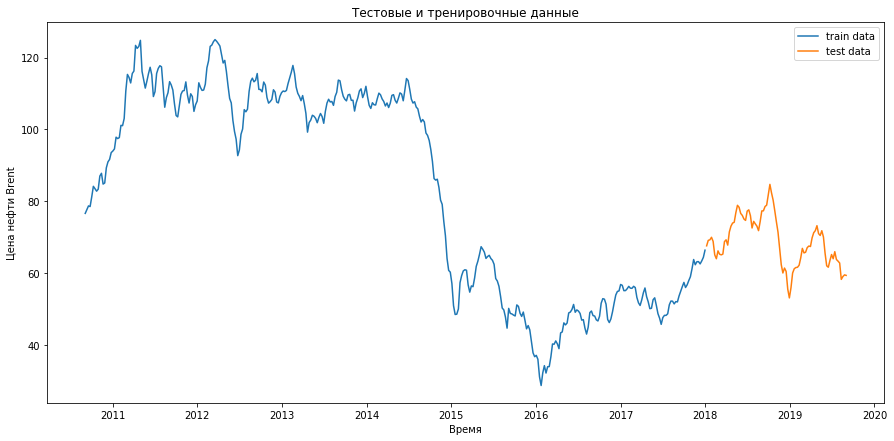

In [50]:
train_g, test_g = split_data(brent_data_wg, '01-01-2018')

plt.figure( figsize=( 15, 7 ))
plt.xlabel('Время')
plt.ylabel('Цена нефти Brent')
plt.plot(train_g.index.get_level_values('Date'),train['Значение'], label='train data' )
plt.plot(test_g.index.get_level_values('Date'),test['Значение'], label='test data')
plt.title( 'Тестовые и тренировочные данные' )
plt.legend()
plt.show()

In [51]:
X_train_g = train_g.iloc[:-h, :]
y_train_g = train_g['Значение'].values[h:]
X_test_g = test_g.iloc[:-h, :]
y_test_g = test_g['Значение'].values[h:]

In [52]:
model_gb_g = GradientBoostingRegressor(max_depth=5, random_state=0, n_estimators=100)
model_gb_g.fit(X_train_g, y_train_g)

GradientBoostingRegressor(alpha=0.9, ccp_alpha=0.0, criterion='friedman_mse',
                          init=None, learning_rate=0.1, loss='ls', max_depth=5,
                          max_features=None, max_leaf_nodes=None,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=1, min_samples_split=2,
                          min_weight_fraction_leaf=0.0, n_estimators=100,
                          n_iter_no_change=None, presort='deprecated',
                          random_state=0, subsample=1.0, tol=0.0001,
                          validation_fraction=0.1, verbose=0, warm_start=False)

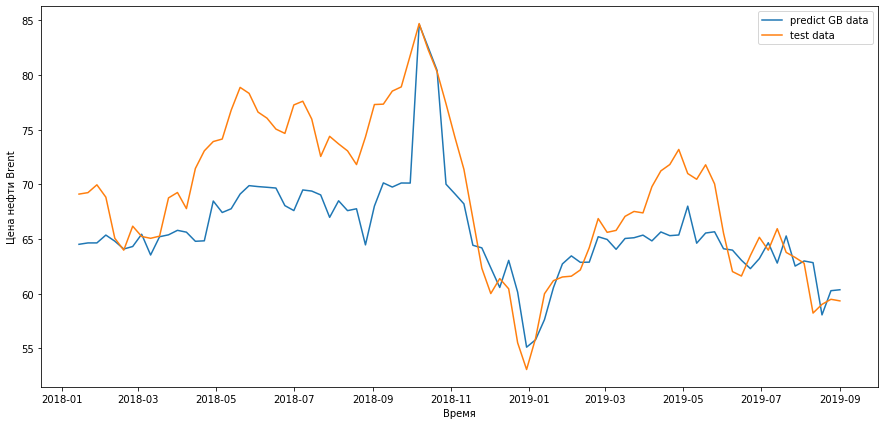

In [54]:
y_test_pred_g_g = model_gb_g.predict(X_test_g)

plt.figure( figsize=( 15, 7 ))


plt.xlabel('Время')
plt.ylabel('Цена нефти Brent')
plt.plot(test_g.index[h:],y_test_pred_g_g, label='predict GB data' )
plt.plot(test_g.index[h:],y_test_g, label='test data')

plt.legend()
plt.show()

In [55]:
er_s_g = mean_squared_error(y_true=y_test_g, y_pred=y_test_pred_g_g) 
er_a_g = mean_absolute_error(y_true=y_test_g, y_pred=y_test_pred_g_g) 
er_r2_g = r2_score(y_true=y_test_g, y_pred=y_test_pred_g_g)

print('ошибка mse :  ', er_s,'\nошибка mae  :  ', er_a,'\nоценка R2 :  ', er_r2)

ошибка mse :   19.969732313398303 
ошибка mae  :   3.6057451645440324 
оценка R2 :   0.5706821632452077


In [56]:
er_g = mean_absolute_percentage_error(y_true=scl_target.inverse_transform( y_test_g),y_pred = scl_target.inverse_transform( y_test_pred_g_g))

print('ошибка градиентного бустинга MAPE :  ', er_g,'%')

ошибка градиентного бустинга MAPE :   5.171060529234906 %


In [57]:
from sklearn.model_selection import RandomizedSearchCV

def report(results, n_top=3):
    for i in range(1, n_top + 1):
        candidates = np.flatnonzero(results['rank_test_score'] == i)
        for candidate in candidates:
            print("Model with rank: {0}".format(i))
            print("Mean validation score: {0:.3f} (std: {1:.3f})".format(
                  results['mean_test_score'][candidate],
                  results['std_test_score'][candidate]))
            print("Parameters: {0}".format(results['params'][candidate]))
            print("")

param_dist = {"max_depth": [3, 2,1,4,5], 
              "n_estimators":[100,200,300,400,500]}

#  randomized search
n_iter_search = 10

model_gr =GradientBoostingRegressor()

random_search = RandomizedSearchCV(model_gr, param_distributions=param_dist, n_iter=n_iter_search, cv=5, iid=False)

random_search.fit(X_train_g, y_train_g)

report(random_search.cv_results_)

Model with rank: 1
Mean validation score: 0.866 (std: 0.097)
Parameters: {'n_estimators': 300, 'max_depth': 1}

Model with rank: 2
Mean validation score: 0.864 (std: 0.101)
Parameters: {'n_estimators': 200, 'max_depth': 1}

Model with rank: 3
Mean validation score: 0.862 (std: 0.088)
Parameters: {'n_estimators': 500, 'max_depth': 3}



In [58]:
model_gb_best_g = GradientBoostingRegressor(max_depth=3,  n_estimators=500)
model_gb_best_g.fit( X_train_g, y_train_g ) 
y_test_pred_g_g = model_gb_best_g.predict(X_test_g)

er_g = mean_absolute_percentage_error(y_true=scl_target.inverse_transform( y_test_g),y_pred = scl_target.inverse_transform( y_test_pred_g_g))
print('ошибка градиентного бустинга MAPE :  ', er_g,'%')

ошибка градиентного бустинга MAPE :   5.67253796612914 %


### Сравните модель с дополнительным экзогенным фактором и исходную и сделайте вывод о поведении ошибки предсказания ряда в сравнении с прямым прогнозированием.

На стандартных настройках ошибка возросла, на "лучших" стало чуть лучше. Можно сделать вывод, что к выбору экзогенных факторов нужно подходить крайне осторожно и фактор может, как улучшить, так и ухудшить модель